In [1]:
import os
import sys
sys.path.append('/global/homes/q/qmxp55/DESI/omarlibs')
import raichoorlib
import numpy as np
np.seterr(divide='ignore') # ignode divide by zero warnings
import astropy.io.fits as fits
import fitsio
import glob
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as units
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#from main_def import get_random


## input files

In [2]:
elgsvdr8 = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.data.fits'
dr8randroot = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/lss-dr8-0.32.0-elgsv.rand.fits'
dr8pix = '/global/cscratch1/sd/raichoor/desits_lss/dr8-0.32.0/pixweight_ar-dr8-0.32.0-elgsv.fits'
desitile = '/global/cscratch1/sd/raichoor/desi-tiles-viewer.fits' # from Eddie, see [desi-survey 647]

## settings

In [3]:
# open pixel catalogue
pixcat = fitsio.read(dr8pix)
#settings
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
# for healpy
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)


## some functions

In [4]:
def get_isdesi(ra,dec):
    radius   = 1.6 # degree
    tmpnside = 16
    tmpnpix  = hp.nside2npix(tmpnside)
    # first reading desi tiles, inside desi footprint (~14k deg2)
    hdu  = fits.open(desitile)
    data = hdu[1].data
    keep = (data['in_desi']==1)
    data = data[keep]
    tra,tdec = data['ra'],data['dec']
    # get hppix inside desi tiles
    theta,phi  = hp.pix2ang(tmpnside,np.arange(tmpnpix),nest=nest)
    hpra,hpdec = 180./np.pi*phi,90.-180./np.pi*theta
    hpindesi   = np.zeros(tmpnpix,dtype=bool)
    _,ind,_,_,_= raichoorlib.search_around(tra,tdec,hpra,hpdec,search_radius=1.6*3600)
    hpindesi[np.unique(ind)] = True
    ## small hack to recover few rejected pixels inside desi. Avoid holes if any
    tmp  = np.array([i for i in range(tmpnpix) 
                     if hpindesi[hp.get_all_neighbours(tmpnside,i,nest=nest)].sum()==8])
    hpindesi[tmp] = True
    ##
    pixkeep    = np.where(hpindesi)[0]
    # now compute the hppix for the tested positions
    pix  = hp.ang2pix(tmpnside,(90.-dec)*np.pi/180.,ra*np.pi/180.,nest=nest)
    keep = np.in1d(pix,pixkeep)
    return keep

# mollweide plot setting
# http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
def set_mwd(ax,org=0):
    # org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_xlabel('R.A [deg]')
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel('Dec. [deg]')
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    return True

# my colormaps
cm = raichoorlib.mycmap(matplotlib.cm.jet, 10,0,1)
cmr= raichoorlib.mycmap(matplotlib.cm.jet_r,10,0,1)

# convert radec for mollwide
def get_radec_mw(ra,dec,org):
    ra          = np.remainder(ra+360-org,360) # shift ra values
    ra[ra>180] -= 360    # scale conversion to [-180, 180]
    ra          =- ra    # reverse the scale: East to the left
    return np.radians(ra),np.radians(dec)

# plot/xlim settings
def get_systplot(systquant):
    tmparray = np.array([
        'stardens',      [2.4,3.7],  r'log10(Stellar density from Gaia/dr2 [deg$^{-2}$])',
        'ebv',           [0.01,0.11],'Galactic extinction ebv [mag]',
        'psfsize_g',     [1,2.6],  'g-band psfsize [arcsec]',
        'psfsize_r',     [1,2.6],  'r-band psfsize [arcsec]',
        'psfsize_z',     [1,2.6],  'z-band psfsize [arcsec]',
        'galdepth_g',    [23.3,25.5],'g-band 5sig. galdepth [mag]',
        'galdepth_r',    [23.1,25],'r-band 5sig. galdepth [mag]',
        'galdepth_z',    [21.6,23.9],'z-band 5sig. galdepth [mag]'],
        dtype='object')
    tmparray = tmparray.reshape(int(tmparray.shape[0]/3),3)
    tmpind   = np.where(tmparray[:,0]==systquant.lower())[0][0]
    return tmparray[tmpind,1], tmparray[tmpind,2]

def plot_sysdens(namesel, syst, mainreg, xlim=None, n=0, nx=20, clip=False, denslims=False, ylab=True):

    hpdens = hpdict[namesel]
    # plot/xlim settings
    if xlim is None:
        xlim, xlabel = get_systplot(syst)
    else:
        _, xlabel = get_systplot(syst)
        
    #do we have inf or nans within syst boundaries
    tmpsyst0 = hpdict[syst]
    mask = (tmpsyst0>xlim[0]) & (tmpsyst0<xlim[1])
    tmpsyst = tmpsyst0[mainreg & mask]
    tmpdens   = hpdens[mainreg & mask]
    #print('%i infs and nans found within %s boundaries (%g, %g)' %(np.sum(~np.isfinite(tmpsyst)), syst, xlim[0], xlim[1]))
    #print('%i infs and nans found in target dens. within %s boundaries (%g, %g)' %(np.sum(~np.isfinite(tmpdens)), syst, xlim[0], xlim[1]))
    
    #xlim = tmpsyst[tmpsyst > 0].min(), tmpsyst[tmpsyst > 0].max()
    if clip: xlim = np.percentile(tmpsyst[tmpsyst>0],(1,99))
    xwidth = (xlim[1]-xlim[0])/nx
        
    # initializing plots
    ax = fig.add_subplot(gs[n])
    ## systematics
    ax.plot(xlim,[1.,1.],color='k',linestyle='--')
    ax.set_xlim(xlim)
    ax.set_ylim(0.8,1.2)
        
    if ylab: ax.set_ylabel(r'n / $\overline{n}$',fontsize=20)
    ax.set_xlabel(xlabel,fontsize=12)
    ax.grid(True)
    title = []
    if clip: title.append('clipped')
    if denslims: title.append('denslims')
    ax.set_title(r'%s (%s)' %(namesel, ' & '.join(title)))
        
    ## histogram
    axh = ax.twinx()
    axh.set_xlim(xlim)
    axh.set_ylim(0,8)
    axh.axes.get_yaxis().set_ticks([])
    
    ## systematics
    cols = ['0.5','b','g','r']
    regs = ['all','des','decals','north']
    densmin,densmax = 0,2
    for reg,col in zip(regs,cols):
        if (reg=='all'):
            isreg    = (mainreg)
            lw,alpha = 3,0.5
        else:
            isreg    = (mainreg) & (hpdict[('is'+reg)])
            lw,alpha = 1,1.0
        tmpsyst   = hpdict[syst][isreg]
        #xlim      = tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].min(), tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))].max()
        #xlim, _ = get_systplot(syst)
        if clip: xlim = np.percentile(tmpsyst[(tmpsyst>0) & (np.isfinite(tmpsyst))],(1,99))
        tmpdens   = hpdens[isreg]
        
        if denslims:
            tmp = ((tmpdens/hpdict['meandens_'+namesel+'_'+reg]>densmin) & 
                     (tmpdens/hpdict['meandens_'+namesel+'_'+reg]<densmax) & 
                     (tmpsyst>xlim[0]) & 
                     (tmpsyst<xlim[1]))
        else:
            tmp       = (tmpsyst>xlim[0]) & (tmpsyst<xlim[1])
            
        systquant = tmpsyst[tmp]
        systdens  = tmpdens[tmp]
        #systdens /= hpdict['meandens_'+namesel+'_'+reg] #density/mean density per bit per region
        systdens /= hpdict['meandens_'+namesel+'_'+'all'] #density/mean density per bit overall desi footprint
        xgrid        = xlim[0]+np.arange(nx+1)/float(nx)*(xlim[1]-xlim[0])
        plotxgrid    = (xgrid[0:-1]+xgrid[1:])/2.
        systnobj     = np.ones(nx)*float('NaN')
        systv        = np.ones(nx)*float('NaN')
        systverr     = np.ones(nx)*float('NaN')
        for j in range(nx):
            tmp      = np.where((systquant >= xgrid[j]) & (systquant < xgrid[j+1]))[0]
            systnobj[j]= len(tmp)
            if (len(tmp) > 0):
            #if ((len(tmp)>0) & (xgrid[j+1]>systmin) & (xgrid[j]<systmax)):
                #print ' ', xgrid[j] , xgrid[j+1], len(systquant[tmp]), np.mean(systdens[tmp])                
                systv[j]   = np.mean(systdens[tmp])
                systverr[j]= np.std(systdens[tmp])/np.sqrt(len(systdens[tmp]))
        tmpl  = 0.05*(xlim[1]-xlim[0])
        tmp = np.isfinite(systv)
        #print syst, t, np.average(systv[tmp],weights=systnobj[tmp]/np.sum(systnobj[tmp]))
        ax.errorbar(plotxgrid,systv,systverr,color=col,ecolor=col,zorder=1,lw=2*lw,alpha=alpha)
        # histogram
        height,_ = np.histogram(systquant,bins=xgrid)
        height   = height.astype(float) / 2.e4
        xcent    = 0.5*(xgrid[1:]+xgrid[:-1])
        if (reg=='all'):
            axh.bar(xcent,height,align='center',width=xwidth,alpha=0.1,color=col)
        axh.step(xcent,height,where='mid',alpha=alpha,lw=lw,color=col)
        

## get mean densities and plot systematics

To plot the target density variation across the systematics a few extra info not available in `dr8pix` file is needed. Such extra info is the `mean target densities` per bit and per region, define the `desi footprint` and `decals footprint` and transform some systematics.

In [5]:
# create new dict with healpix info we need
hpdict = {}

# positions and regions
for key in ['RA', 'DEC', 'ISNORTH', 'ISSOUTH', 'ISDES', 'ELGFRACAREA']:
    hpdict[key.lower()] = pixcat[key]
    
hpdict['isdesi'] = get_isdesi(hpdict['ra'],hpdict['dec'])
hpdict['isdecals'] = (hpdict['issouth']) & (~hpdict['isdes'])

# systematics
for key in ['HPXPIXEL', 'FRACAREA', 
            'STARDENS', 'EBV', 
            'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z',
            'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z',
            'PSFDEPTH_W1', 'PSFDEPTH_W2',
            'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z']:
    if (key=='STARDENS'):
        hpdict[key.lower()] = np.log10(pixcat[key])
    elif (key[:8]=='GALDEPTH'):
        hpdict[key.lower()] = 22.5-2.5*np.log10(5./np.sqrt(pixcat[key]))
    else:
        hpdict[key.lower()] = pixcat[key]
        
# elg's hp densities in bits and mean densities
mask = (hpdict['elgfracarea']>0) & (hpdict['isdesi'])
for namesel in ['SV', 'BLUE', 'RED']:
    
    hpdict[namesel.lower()] = pixcat[namesel]
    hpdens = hpdict[namesel.lower()]
    
    for reg in ['all','des','decals','north']:
        if (reg=='all'):
            hpdict['meandens_'+namesel.lower()+'_'+reg] = np.nanmean(hpdens[mask])
        else:
            hpdict['meandens_'+namesel.lower()+'_'+reg] = np.nanmean(hpdens[(mask) & (hpdict[('is'+reg)])])
        print('meandens_'+namesel.lower()+'_'+reg+' = '+'%.0f'%hpdict['meandens_'+namesel.lower()+'_'+reg]+' /deg2')
        

1207 nearby objects
meandens_sv_all = 5257 /deg2
meandens_sv_des = 4733 /deg2
meandens_sv_decals = 5181 /deg2
meandens_sv_north = 5523 /deg2
meandens_blue_all = 862 /deg2
meandens_blue_des = 758 /deg2
meandens_blue_decals = 863 /deg2
meandens_blue_north = 883 /deg2
meandens_red_all = 1327 /deg2
meandens_red_des = 1236 /deg2
meandens_red_decals = 1306 /deg2
meandens_red_north = 1387 /deg2


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt


plotting density distributions + systematics for the  sv selection


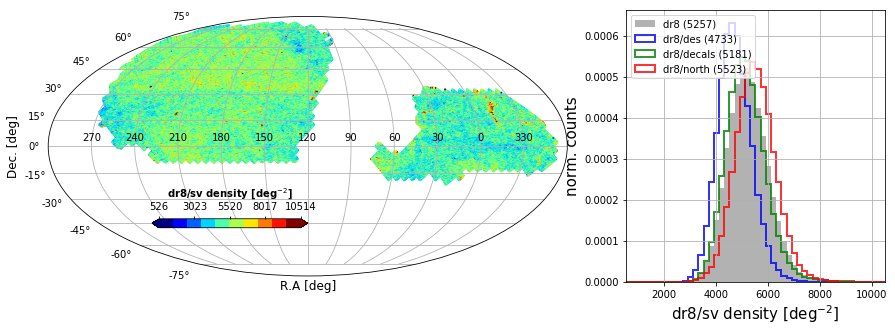

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in greater
/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in less




plotting density distributions + systematics for the  blue selection


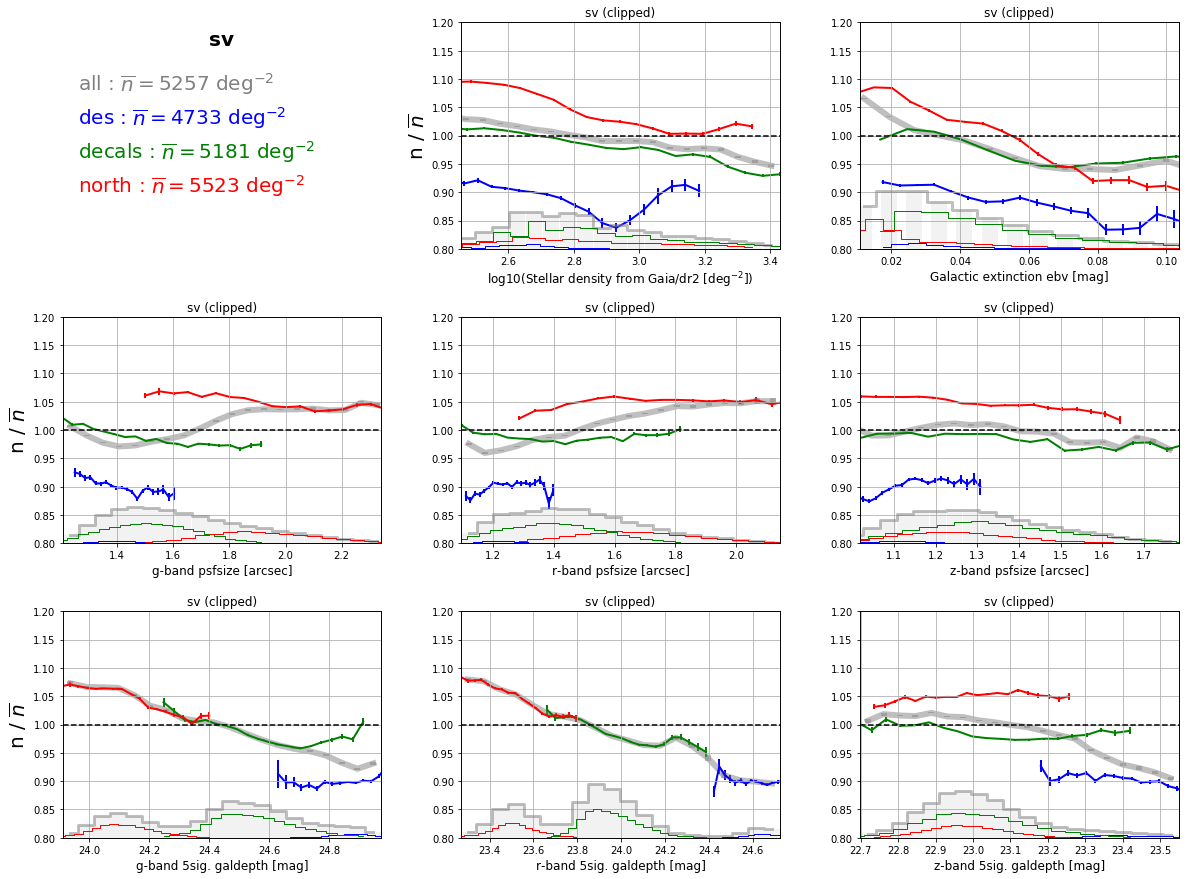

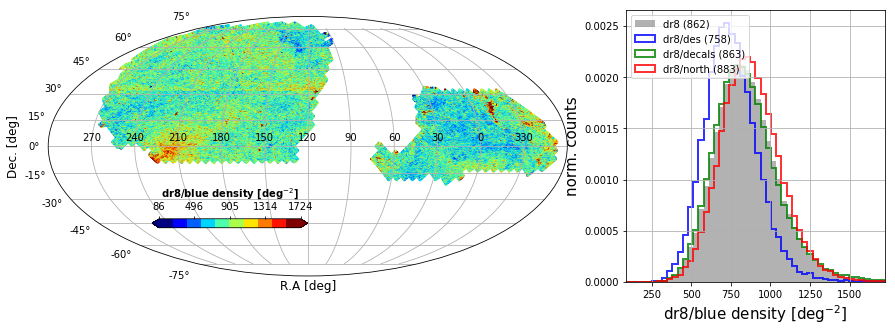



plotting density distributions + systematics for the  red selection


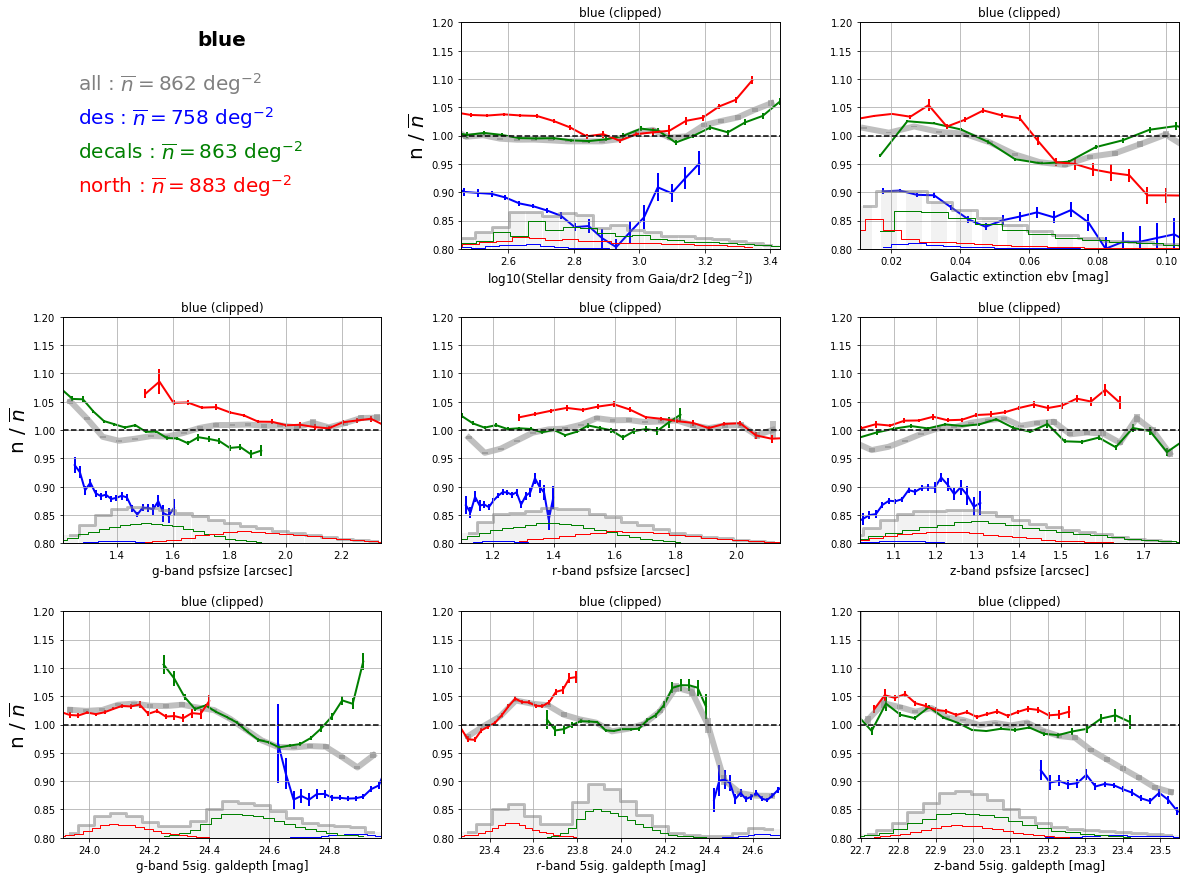

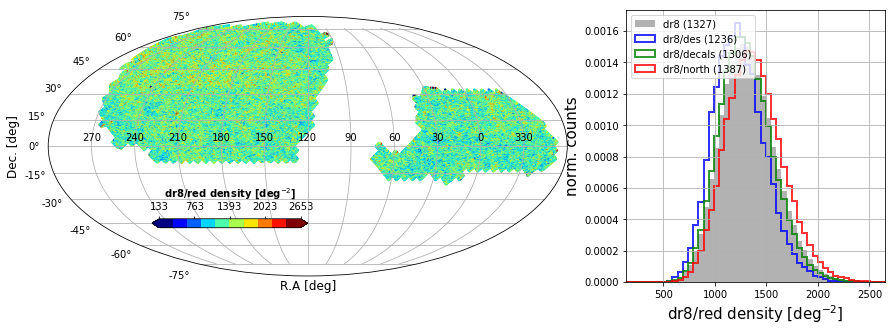

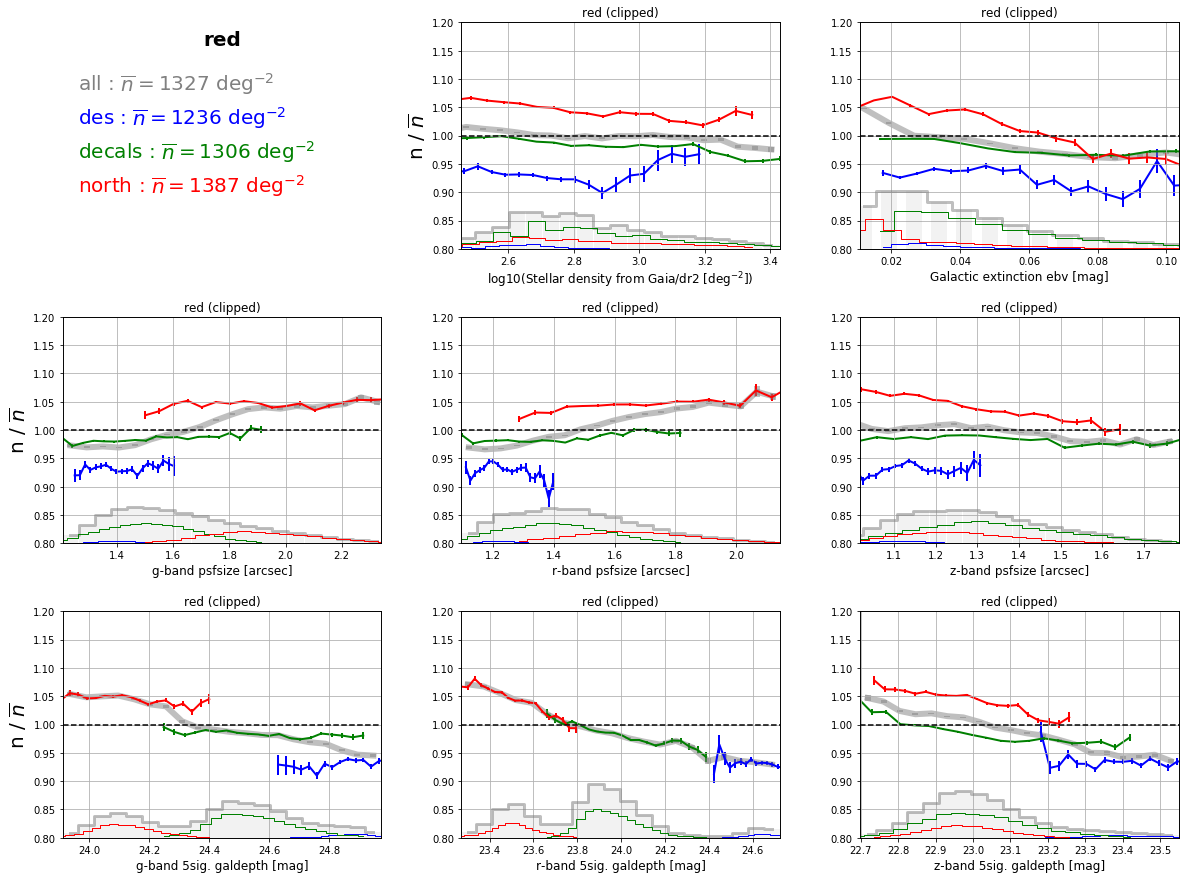

In [6]:
# dr8_south+north : density distributions + systematics
#print(raichoorlib.get_date(), 'start')

# subsamples (BGS SV supersets)
namesels = ['sv', 'blue', 'red']

# settings
isdesi = (hpdict['elgfracarea']>0) & (hpdict['isdesi'])
ramw,decmw = get_radec_mw(hpdict['ra'],hpdict['dec'],org)
systs      = ['stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
densmin,densmax = 0,2
regs       = ['all','des','decals','north']
cols       = ['0.5','b','g','r']

# looping on subselections
for namesel in namesels:
    
    print('plotting density distributions + systematics for the ', namesel, 'selection')
    
    hpdens = hpdict[namesel]
    hpmean = hpdict['meandens_'+namesel+'_all']
    cmin,cmax = (0.1*hpmean,2*hpmean)
    cbarticks = np.linspace(cmin,cmax,5)
    cbar_ylab = ['%.0f' % x for x in cbarticks]
    clab      = 'dr8/'+namesel+r' density [deg$^{-2}$]'

    # density skymap + hist
    fig        = plt.figure(figsize=(15,5))
    gs         = gridspec.GridSpec(1,2,wspace=0.15,hspace=0.3,width_ratios=[2,1])
    # mollweide
    ax     = plt.subplot(gs[0],projection=projection)
    _      = set_mwd(ax,org=org)
    SC  = ax.scatter(ramw[isdesi],decmw[isdesi],s=1,
        c=hpdens[isdesi],
        cmap=cm,vmin=cmin,vmax=cmax,rasterized=True)
    p  = ax.get_position().get_points().flatten()
    cax= fig.add_axes([p[0]+0.2*(p[2]-p[0]),p[1]+0.2*(p[3]-p[1]),0.3*(p[2]-p[0]),0.025])
    cbar = plt.colorbar(SC, cax=cax, orientation='horizontal', ticklocation='top', extend='both', ticks=cbarticks)
    cbar.set_label(clab,fontweight='bold')
    cbar.ax.set_yticklabels(cbar_ylab)
    # hist
    ax     = plt.subplot(gs[1])
    xgrid  = np.linspace(cmin,cmax,51)
    ax.hist(hpdens[isdesi],
            bins=xgrid,histtype='stepfilled',alpha=0.3,color='k',density=True,
            label='dr8 ('+'%.0f'%hpdict['meandens_'+namesel+'_all']+')')
    for reg,col in zip(regs[1:],cols[1:]):
        tmp = (isdesi) & (hpdict[('is'+reg)])
        ax.hist(hpdens[tmp],
                bins=xgrid,histtype='step',alpha=0.8,color=col,lw=2,density=True,
                label='dr8/'+reg+' ('+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+')')
    ax.set_xlabel(clab,fontsize=15)
    ax.set_ylabel('norm. counts',fontsize=15)
    ax.set_xlim(cmin,cmax)
    #ax.set_ylim(0,5)
    ax.grid(True)
    ax.legend(ncol=1,loc=2)
    plt.show()
    plt.close()
            
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            for reg,col in zip(regs,cols):
                tmpstr = reg+' : '+r'$\overline{n}=$'+'%.0f'%hpdict['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=20,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            plot_sysdens(namesel=namesel, syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, denslims=False, ylab=ylab)
        
    print('')
    print('')